In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import os

dataset_path = "Dataset/train"
classes = os.listdir(dataset_path)

for cls in classes:
    count = len(os.listdir(os.path.join(dataset_path, cls)))
    print(f"{cls}: {count} images")

angry: 3993 images
disgust: 436 images
fear: 4103 images
happy: 7164 images
neutral: 4982 images
sad: 4938 images
surprise: 3205 images


In [6]:
import os
import cv2
import glob
import random
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def balance_dataset(input_dir, output_dir, target_size=(48, 48)):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    os.makedirs(output_dir, exist_ok=True)

    class_counts = {}
    class_paths = {}
    ignore_folders = ["images", "labels"]

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if os.path.isdir(cls_path) and cls not in ignore_folders:
            image_files = glob.glob(os.path.join(cls_path, "*[.jpg|.jpeg|.png]"))
            if image_files:
                class_counts[cls] = len(image_files)
                class_paths[cls] = image_files

    if not class_counts:
        print("No image classes found in the input directory.")
        return

    print("Class distribution before balancing:", class_counts)
    max_count = max(class_counts.values())
    print(f"Largest class has {max_count} images. Others will be augmented to match.")

    for cls, count in class_counts.items():
        output_class_dir = os.path.join(output_dir, cls)
        os.makedirs(output_class_dir, exist_ok=True)

        original_images = class_paths[cls]
        for img_file in original_images:
            shutil.copy(img_file, output_class_dir)

        missing_count = max_count - count
        if missing_count > 0:
            print(f"Augmenting '{cls}': adding {missing_count} images ({count} → {max_count})")
            
            for i in range(missing_count):
                img_path = random.choice(original_images)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    continue
                    
                img = cv2.resize(img, target_size)
                img = img.reshape((1,) + img.shape + (1,))

                for _ in datagen.flow(img, batch_size=1,
                                      save_to_dir=output_class_dir,
                                      save_prefix="aug",
                                      save_format="jpg"):
                    break # Exit after saving one image

    print("\nBalancing complete! Final class distribution:")
    final_counts = {cls: len(os.listdir(os.path.join(output_dir, cls))) for cls in class_counts.keys()}
    print(final_counts)


# dataset paths
INPUT_DATASET_PATH = "Dataset/train"
BALANCED_DATASET_PATH = "dataset_balanced/train"
balance_dataset(INPUT_DATASET_PATH, BALANCED_DATASET_PATH)

Class distribution before balancing: {'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}
Largest class has 7164 images. Others will be augmented to match.
Augmenting 'angry': adding 3171 images (3993 → 7164)
Augmenting 'disgust': adding 6728 images (436 → 7164)
Augmenting 'fear': adding 3061 images (4103 → 7164)
Augmenting 'neutral': adding 2182 images (4982 → 7164)
Augmenting 'sad': adding 2226 images (4938 → 7164)
Augmenting 'surprise': adding 3959 images (3205 → 7164)

Balancing complete! Final class distribution:
{'angry': 6698, 'disgust': 5351, 'fear': 6725, 'happy': 7164, 'neutral': 6971, 'sad': 6923, 'surprise': 6473}


## Data Loading and Preprocessing

In [3]:
data_dir = 'Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
model_dir = 'Models'

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 46267 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## EDA

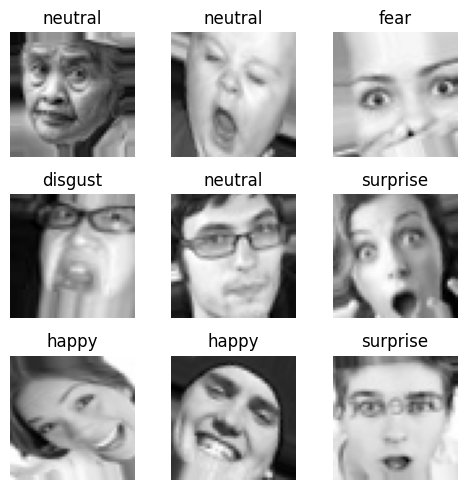

In [5]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].reshape(48,48), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

## CNN Model Architecture

In [11]:
def create_model():
    model = Sequential([
        #1st ConV
        Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(48,48,1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        
        #2nd ConV
        Conv2D(128, (3,3),padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
    
        #3rd ConV
        Conv2D(256, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
    
        Flatten(),
        
        # Classification
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(256, activation='relu'), # Added Dense layer
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'), # Added Dense layer
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(7, activation='softmax'),
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Create / Load Model

In [12]:
best_model_path = os.path.join(model_dir,'best_model.h5')
best_weights_path = os.path.join(model_dir,'best_weights.h5')

if os.path.exists(best_model_path):
    print("\nResuming from saved model...\n")
    model = load_model(best_model_path)
elif os.path.exists(best_weights_path):
    print("\nResuming from saved weights...\n")
    model = create_model()
    model.load_weights(best_weights_path)
else:
    print("\nStarting from scratch...\n")
    model = create_model()
    
model.summary()


Resuming from saved model...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (B

## Checkpoints, Callbacks and Model Training

In [ ]:
# Callabcks

# Checkpoint for best Weights
checkpoint_weights = ModelCheckpoint(
    filepath=os.path.join(model_dir,'best_weights.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Checkpoint for best full model
checkpoint_model = ModelCheckpoint(
    filepath=os.path.join(model_dir,'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3,  
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, lr_scheduler, checkpoint_weights, checkpoint_model]
)

## Performance Evaluation

2/2 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

       angry       0.25      0.25      0.25         4
     disgust       0.50      1.00      0.67         1
        fear       0.75      0.60      0.67         5
       happy       0.90      0.90      0.90        21
     neutral       0.50      0.64      0.56        11
         sad       0.82      0.75      0.78        12
    surprise       0.88      0.70      0.78        10

    accuracy                           0.73        64
   macro avg       0.66      0.69      0.66        64
weighted avg       0.75      0.73      0.74        64



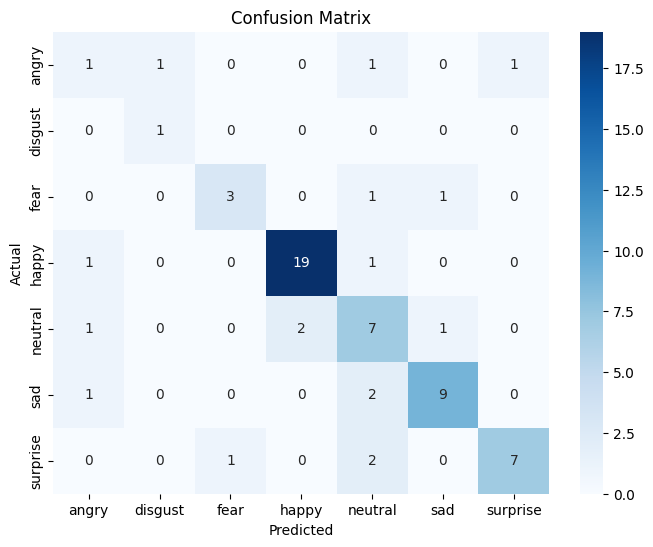

In [9]:
val_images, val_labels = next(test_generator)
predictions = model.predict(val_images)

y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.734375